In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from pathlib import Path
from scipy.special import comb
import seaborn as sns

# Constants
patients = ['001', '002', '004', '006', '007', '008']
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
prediction_horizon = 12  # Using the model from directory 12
model_path = f'models/pixtral-large-latest/{prediction_horizon}'



# Load Bezier parameters
with open('parameters/patient_bezier_params.json', 'r') as f:
    patient_params = json.load(f)

In [66]:
# Load models and get feature names
def load_models():
    models = {}
    feature_names = {}
    for patient in patients:
        model_file = Path(model_path) / f'patient_{patient}_model.pkl'
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
            models[patient] = model
            feature_names[patient] = model.feature_name_
    return models, feature_names

# Constants
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
insulin_features = ['fast_insulin', 'slow_insulin']
carb_features = ['simple_sugars', 'complex_sugars']
fat_protein_features = ['fats', 'proteins']
features_to_remove = ['glucose_next', 'datetime']
patients = ['001', '002', '004', '006', '007', '008']
approaches = ['pixtral-large-latest', 'nollm']
prediction_horizons = [6, 9, 12, 18, 24]

# Optimization parameters
train_size = 0.9
n_trials = 100
random_seed = 42
n_jobs = 6


def bernstein_poly(i, n, t):
    """Bernstein polynomial basis for Bezier curves"""
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=50):
    """Generate Bezier curve from control points"""
    n = len(points) - 1  # Degree of curve is n
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i, point in enumerate(points):
        curve += np.outer(bernstein_poly(i, n, t), point)
    
    # Sort curve by x-values to ensure function-like behavior
    indices = np.argsort(curve[:, 0])
    curve = curve[indices]
    
    # Remove any duplicate x-values (keeping the first occurrence)
    _, unique_indices = np.unique(curve[:, 0], return_index=True)
    unique_indices.sort()
    curve = curve[unique_indices]
    
    return curve

def get_projected_value(window, prediction_horizon):
    x = np.arange(len(window))
    coeffs = np.polyfit(x, window, deg=3)
    return np.polyval(coeffs, len(window) + prediction_horizon)

def get_data(patient, food_data, prediction_horizon):
    # Load data
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")

    # Process glucose data
    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data = glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1)
    glucose_data['glucose'] *= 18.0182
    glucose_data['hour'] = glucose_data['datetime'].dt.hour

    # Process insulin data
    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data = insulin_data.drop(['comment', 'date', 'time'], axis=1)

    # Combine data
    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)

    # Calculate target variables
    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)
    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)
    
    window_size = 6
    glucose_data['glucose_change_projected'] = glucose_data['glucose_change'].rolling(
        window=window_size, min_periods=window_size
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    
    glucose_data['glucose_projected'] = glucose_data['glucose'].rolling(
        window=window_size, min_periods=window_size
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    
    glucose_data.dropna(subset=['glucose_next'], inplace=True)
    return glucose_data, combined_data

def add_features_bezier(params, features, preprocessed_data, prediction_horizon, patient):
    glucose_data, combined_data = preprocessed_data
    
    # Convert datetime to nanoseconds for efficient vectorized operations
    glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    
    # Calculate time difference matrix (in hours)
    time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
    
    for feature in features:
        # Extract control points from params
        control_points = np.array(params[feature]).reshape(-1, 2)
        
        # Generate Bezier curve
        curve = bezier_curve(control_points, num=100)
        x_curve, y_curve = curve[:, 0], curve[:, 1]
        
        # Create weights array
        weights = np.zeros_like(time_diff_hours, dtype=np.float32)
        
        # For each time difference, find the closest point on bezier curve
        for i in range(len(glucose_times)):
            for j in range(len(combined_times)):
                if time_diff_hours[i, j] >= 0 and time_diff_hours[i, j] <= max(x_curve):
                    # Find closest x value in curve
                    idx = np.abs(x_curve - time_diff_hours[i, j]).argmin()
                    weights[i, j] = y_curve[idx]
        
        # Compute impact and shift by prediction horizon
        glucose_data[feature] = np.dot(weights, combined_data[feature].values)
        glucose_data[feature] = glucose_data[feature].shift(-prediction_horizon) - glucose_data[feature]
    
    return glucose_data

def modify_macronutrients(food_data, nutrient, amount):
    """Modify a specific macronutrient by a given amount."""
    modified_food_data = food_data.copy()
    modified_food_data[nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [67]:
# Main evaluation loop
approach = 'pixtral-large-latest'
prediction_horizon = 12
patient = '004'
models, feature_names = load_models()
model = models[patient]
# Get patient-specific feature parameters
patient_feature_params = patient_params[patient].copy()
feature = 'proteins'
increment = 50
food_data = pd.read_csv(f"food_data/pixtral-large-latest/{patient}.csv")
modified_food_data = modify_macronutrients(food_data, feature, increment)
# Process food data
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]
data = get_data(patient, food_data, prediction_horizon)
processed_data = add_features_bezier(
    {k: v for k, v in patient_feature_params.items() if k in features},
    features,
    data, 
    prediction_horizon, patient
)
X_test_modified = processed_data.drop(features_to_remove, axis=1)
preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)

In [68]:
# Create DataFrame to store results
results_df = pd.DataFrame(columns=['feature', 'increment', 'hyper_minutes', 'hypo_minutes', 'mean_glucose', 'patient'])
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50] 
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
# Simulate additions/subtractions for each feature
for feature in meal_features:
    for increment in increments:
        patient_hyper_times = []
        patient_hypo_times = []
        patient_means = []
        for patient in patients:
            # Load patient model
            model = models[patient]
            food_data = pd.read_csv(f"food_data/pixtral-large-latest/{patient}.csv")
            food_data = modify_macronutrients(food_data, feature, increment)
            # Process food data
            food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
            food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]
            data = get_data(patient, food_data, prediction_horizon)
            patient_feature_params = patient_params[patient].copy()
            processed_data = add_features_bezier(
                {k: v for k, v in patient_feature_params.items() if k in features},
                features,
                data, 
                prediction_horizon, patient
            )
            X_test_modified = processed_data.drop(features_to_remove, axis=1)
            preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)



            # Convert predictions to binary indicators and calculate time in minutes
            hyper_binary_preds = (preds_modified >= 180).astype(int)
            hypo_binary_preds = (preds_modified <= 70).astype(int)
            
            hyperglycemia_count = np.sum(hyper_binary_preds)
            hypoglycemia_count = np.sum(hypo_binary_preds)
            
            hyperglycemia_hours = hyperglycemia_count / 12
            hypoglycemia_hours = hypoglycemia_count / 12
            
            patient_hyper_times.append(hyperglycemia_hours)
            patient_hypo_times.append(hypoglycemia_hours)
            patient_means.append(np.mean(preds_modified))

            # Average time and glucose levels across patients
            total_hyper_time = np.mean(patient_hyper_times)
            total_hypo_time = np.mean(patient_hypo_times)
            mean_glucose = np.mean(patient_means)

            # Store in DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'feature': [feature],
                'increment': [increment],
                'hyper_minutes': [total_hyper_time],
                'hypo_minutes': [total_hypo_time],
                'mean_glucose': [mean_glucose],
                'patient': [patient]
            })])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


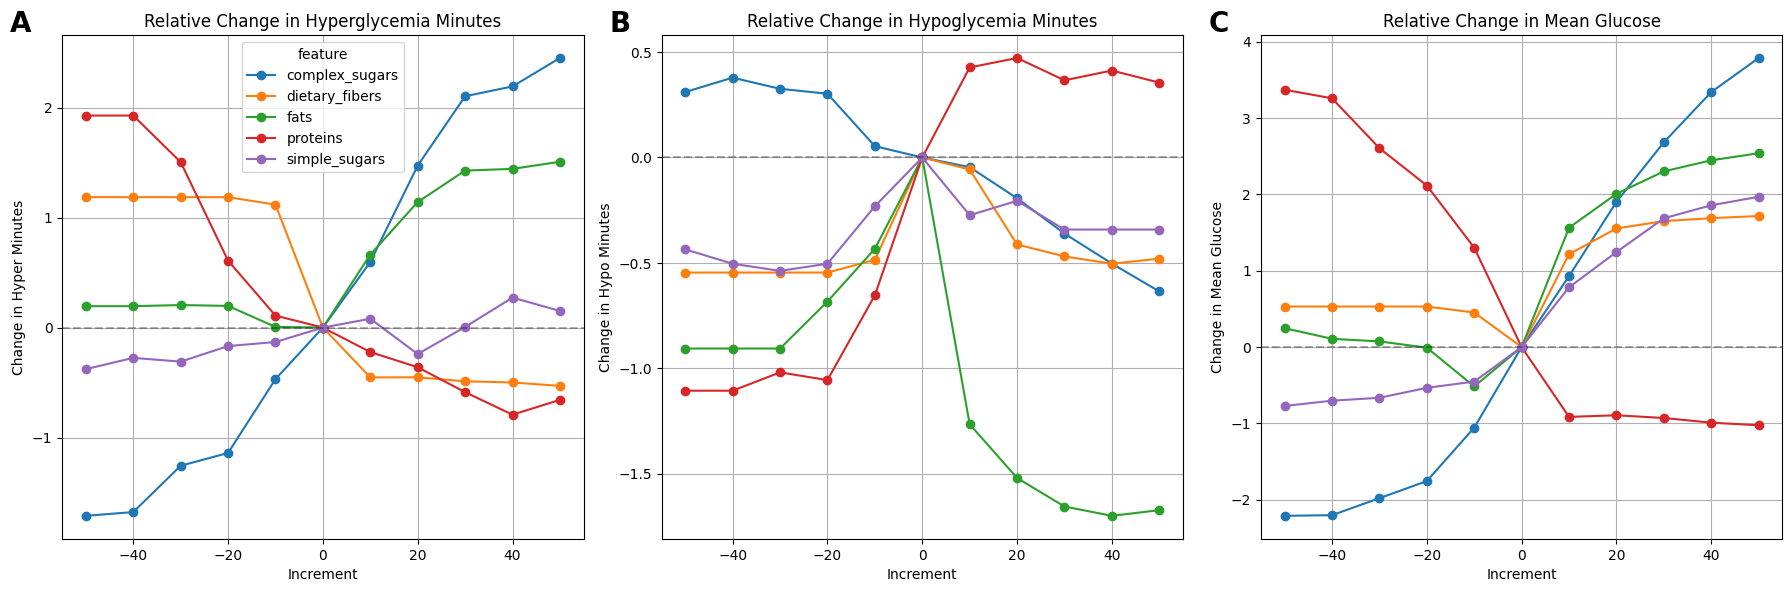

In [79]:
# Create pivot table
glucose_pivot_df = results_df.pivot_table(
    index='increment',
    columns='feature',
    values=['hyper_minutes', 'hypo_minutes', 'mean_glucose']
)

# Get baseline values (increment = 0)
baseline = glucose_pivot_df.loc[0]

# Calculate relative changes
relative_glucose_df = glucose_pivot_df.copy()
for metric in ['hyper_minutes', 'hypo_minutes', 'mean_glucose']:
    for feature in glucose_pivot_df[metric].columns:
        relative_glucose_df[metric, feature] = glucose_pivot_df[metric, feature] - baseline[metric, feature]

# Plot relative changes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot relative hyper_minutes with legend
relative_glucose_df['hyper_minutes'].plot(ax=axes[0], marker='o')
axes[0].set_title('Relative Change in Hyperglycemia Minutes') 
axes[0].set_xlabel('Increment')
axes[0].set_ylabel('Change in Hyper Minutes')
axes[0].grid(True)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=20, fontweight='bold', va='top')

# Plot relative hypo_minutes without legend
relative_glucose_df['hypo_minutes'].plot(ax=axes[1], marker='o', legend=False)
axes[1].set_title('Relative Change in Hypoglycemia Minutes')
axes[1].set_xlabel('Increment')
axes[1].set_ylabel('Change in Hypo Minutes')
axes[1].grid(True)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=20, fontweight='bold', va='top')

# Plot relative mean_glucose without legend
relative_glucose_df['mean_glucose'].plot(ax=axes[2], marker='o', legend=False)
axes[2].set_title('Relative Change in Mean Glucose')
axes[2].set_xlabel('Increment')
axes[2].set_ylabel('Change in Mean Glucose')
axes[2].grid(True)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes, fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('images/relative_changes.eps')
plt.show()